# Example 2: 1st-level Analysis

In this example we will take the preprocessed output from the first example and run for each subject a 1st-level analysis. For this we need to do the following steps:

1. Extract onset times of stimuli from TVA file
2. Specify the model (TR, high pass filter, onset times, etc.)
3. Specify contrasts to compute
4. Estimate contrasts

In the previous example, we used two different smoothing kernels of fwhm=4 and fwhm=8. Therefore, let us also run the 1st-level analysis for those two versions.

**So, let's begin!**

# Imports

First, we need to import all modules we later want to use.

In [1]:
%pylab inline
from os.path import join as opj
import json
from nipype.interfaces.spm import Level1Design, EstimateModel, EstimateContrast
from nipype.algorithms.modelgen import SpecifySPMModel
from nipype.interfaces.utility import Function, IdentityInterface
from nipype.interfaces.io import SelectFiles, DataSink
from nipype.pipeline.engine import Workflow, Node

Populating the interactive namespace from numpy and matplotlib


# Experiment parameters

It's always a good idea to specify all parameters that might change between experiments at the beginning of your script.

In [2]:
experiment_dir = '/output'
output_dir = 'datasink'
working_dir = 'workingdir'

# list of subject identifiers
subject_list = ['sub-01', 'sub-02']

# TR of functional images
with open('/data/ds000114/task-fingerfootlips_bold.json', 'rt') as fp:
    task_info = json.load(fp)
TR = task_info['RepetitionTime']

# Smoothing withds used during preprocessing
fwhm = [4, 8]

# Specify Nodes

Initiate all the different interfaces (represented as nodes) that you want to use in your workflow.

In [3]:
# SpecifyModel - Generates SPM-specific Model
modelspec = Node(SpecifySPMModel(concatenate_runs=False,
                                 input_units='secs',
                                 output_units='secs',
                                 time_repetition=TR,
                                 high_pass_filter_cutoff=128),
                 name="modelspec")

# Level1Design - Generates an SPM design matrix
level1design = Node(Level1Design(bases={'hrf': {'derivs': [1, 0]}},
                                 timing_units='secs',
                                 interscan_interval=TR,
                                 model_serial_correlations='FAST'),
                    name="level1design")

# EstimateModel - estimate the parameters of the model
level1estimate = Node(EstimateModel(estimation_method={'Classical': 1}),
                      name="level1estimate")

# EstimateContrast - estimates contrasts
level1conest = Node(EstimateContrast(), name="level1conest")

# Specify GLM contrasts

To do any GLM analysis, we need to also define the contrasts that we want to investigate. If we recap, we had three different conditions in the **fingerfootlips** task in this dataset:

- **finger**
- **foot**
- **lips**

Therefore, we could create the following contrasts:

In [4]:
# Condition names
condition_names = ['Finger', 'Foot', 'Lips']

# Contrasts
cont01 = ['average',        'T', condition_names, [1/3., 1/3., 1/3.]]
cont02 = ['Finger',         'T', condition_names, [1, 0, 0]]
cont03 = ['Foot',           'T', condition_names, [0, 1, 0]]
cont04 = ['Lips',           'T', condition_names, [0, 0, 1]]
cont05 = ['Finger > others','T', condition_names, [1, -0.5, -0.5]]
cont06 = ['Foot > others',  'T', condition_names, [-0.5, 1, -0.5]]
cont07 = ['Lips > others',  'T', condition_names, [-0.5, -0.5, 1]]

cont08 = ['activation',     'F', [cont02, cont03, cont04]]
cont09 = ['differences',    'F', [cont05, cont06, cont07]]

contrast_list = [cont01, cont02, cont03, cont04, cont05, cont06, cont07, cont08, cont09]

# Specify GLM Model

The next step is now to get information such as stimuli onset, duration and other regressors into the GLM model. For this we need to create a helper function, in our case called ``subjectinfo``.

To recap, let's see what we have in the TSV file for each run:

In [5]:
!cat /data/ds000114/task-fingerfootlips_events.tsv

onset	duration	weight	trial_type
10	15.0	1	Finger
40	15.0	1	Foot
70	15.0	1	Lips
100	15.0	1	Finger
130	15.0	1	Foot
160	15.0	1	Lips
190	15.0	1	Finger
220	15.0	1	Foot
250	15.0	1	Lips
280	15.0	1	Finger
310	15.0	1	Foot
340	15.0	1	Lips
370	15.0	1	Finger
400	15.0	1	Foot
430	15.0	1	Lips


So what we need is the onset and the stimuli type, i.e. **column 0** and **column 3**.

In [6]:
import pandas as pd
trialinfo = pd.read_table('/data/ds000114/task-fingerfootlips_events.tsv')
trialinfo

,onset,duration,weight,trial_type
0,10,15.0,1,Finger
1,40,15.0,1,Foot
2,70,15.0,1,Lips
3,100,15.0,1,Finger
4,130,15.0,1,Foot
5,160,15.0,1,Lips
6,190,15.0,1,Finger
7,220,15.0,1,Foot
8,250,15.0,1,Lips
9,280,15.0,1,Finger


And finally we need to separate the onsets of the two stimuli. This can be done as follows:

In [7]:
for group in trialinfo.groupby('trial_type'):
    print(group)

('Finger',     onset  duration  weight trial_type
0      10      15.0       1     Finger
3     100      15.0       1     Finger
6     190      15.0       1     Finger
9     280      15.0       1     Finger
12    370      15.0       1     Finger)
('Foot',     onset  duration  weight trial_type
1      40      15.0       1       Foot
4     130      15.0       1       Foot
7     220      15.0       1       Foot
10    310      15.0       1       Foot
13    400      15.0       1       Foot)
('Lips',     onset  duration  weight trial_type
2      70      15.0       1       Lips
5     160      15.0       1       Lips
8     250      15.0       1       Lips
11    340      15.0       1       Lips
14    430      15.0       1       Lips)


Now, let us incorporate all this in the helper function ``subjectinfo``.

In [8]:
def subjectinfo(subject_id):

    import pandas as pd
    from nipype.interfaces.base import Bunch
    
    trialinfo = pd.read_table('/data/ds000114/task-fingerfootlips_events.tsv')
    trialinfo.head()
    conditions = []
    onsets = []
    durations = []

    for group in trialinfo.groupby('trial_type'):
        conditions.append(group[0])
        onsets.append(list(group[1].onset - 10))
        durations.append(group[1].duration.tolist())

    subject_info = [Bunch(conditions=conditions,
                          onsets=onsets,
                          durations=durations,
                          #amplitudes=None,
                          #tmod=None,
                          #pmod=None,
                          #regressor_names=None,
                          #regressors=None
                         )]

    return subject_info  # this output will later be returned to infosource

# Get Subject Info - get subject specific condition information
getsubjectinfo = Node(Function(input_names=['subject_id'],
                               output_names=['subject_info'],
                               function=subjectinfo),
                      name='getsubjectinfo')

# Specify input & output stream

Specify where the input data can be found & where and how to save the output data.

In [9]:
# Infosource - a function free node to iterate over the list of subject names
infosource = Node(IdentityInterface(fields=['subject_id',
                                            'fwhm_id',
                                            'contrasts'],
                                    contrasts=contrast_list),
                  name="infosource")
infosource.iterables = [('subject_id', subject_list),
                        ('fwhm_id', fwhm)]

# SelectFiles - to grab the data (alternativ to DataGrabber)
templates = {'func': opj(output_dir, 'preproc', '{subject_id}', 'task-{task_id}',
                         'fwhm-{fwhm_id}', 's{subject_id}_ses-test_task-{task_id}_bold_roi_mcf_flirt.nii'),
             'mc_param': opj(output_dir, 'preproc', '{subject_id}', 'task-{task_id}',
                             '{subject_id}_ses-test_task-{task_id}_bold_roi_mcf.par')}
selectfiles = Node(SelectFiles(templates,
                               base_directory=experiment_dir,
                               sort_filelist=True),
                   name="selectfiles")
selectfiles.inputs.task_id = 'fingerfootlips'

# Datasink - creates output folder for important outputs
datasink = Node(DataSink(base_directory=experiment_dir,
                         container=output_dir),
                name="datasink")

# Use the following DataSink output substitutions
substitutions = [('_subject_id_', '')]
subjFolders = [('_fwhm_id_%s%s' % (f, sub), '%s/fwhm-%s' % (sub, f))
               for f in fwhm
               for sub in subject_list]
substitutions.extend(subjFolders)
datasink.inputs.substitutions = substitutions

# Specify Workflow

Create a workflow and connect the interface nodes and the I/O stream to each other.

In [10]:
# Initiation of the 1st-level analysis workflow
l1analysis = Workflow(name='l1analysis')
l1analysis.base_dir = opj(experiment_dir, working_dir)

# Connect up the 1st-level analysis components
l1analysis.connect([(infosource, selectfiles, [('subject_id', 'subject_id'),
                                               ('fwhm_id', 'fwhm_id')]),
                    (infosource, getsubjectinfo, [('subject_id',
                                                   'subject_id')]),
                    (getsubjectinfo, modelspec, [('subject_info',
                                                  'subject_info')]),
                    (infosource, level1conest, [('contrasts', 'contrasts')]),
                    (selectfiles, modelspec, [('func', 'functional_runs')]),
                    (selectfiles, modelspec, [('mc_param',
                                               'realignment_parameters')]),
                    (modelspec, level1design, [('session_info',
                                                'session_info')]),
                    (level1design, level1estimate, [('spm_mat_file',
                                                     'spm_mat_file')]),
                    (level1estimate, level1conest, [('spm_mat_file',
                                                     'spm_mat_file'),
                                                    ('beta_images',
                                                     'beta_images'),
                                                    ('residual_image',
                                                     'residual_image')]),
                    (level1conest, datasink, [('spm_mat_file',
                                               '1stLevel.@spm_mat'),
                                              ('spmT_images', '1stLevel.@T'),
                                              ('con_images', '1stLevel.@con'),
                                              ('spmF_images', '1stLevel.@F'),
                                              ('ess_images', '1stLevel.@ess'),
                                              ]),
                    ])

# Visualize the workflow

It always helps to visualize your workflow.

170727-06:14:56,12 workflow INFO:
	 Generated workflow graph: /output/workingdir/l1analysis/graph.dot.png (graph2use=colored, simple_form=True).


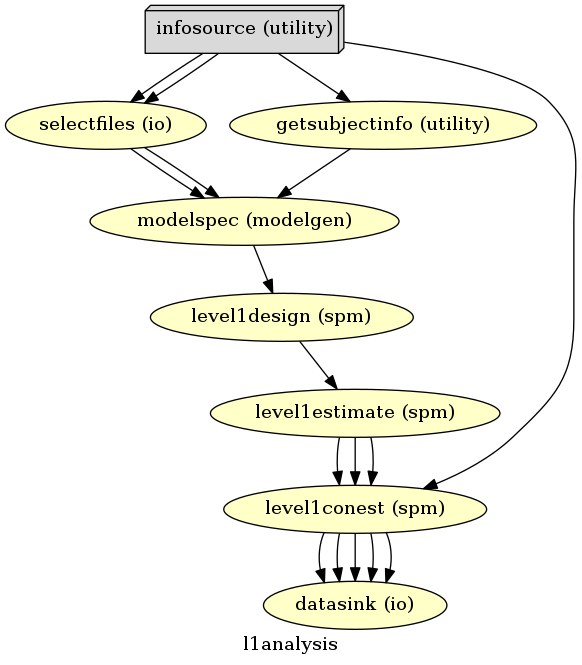

In [11]:
# Create 1st-level analysis output graph
l1analysis.write_graph(graph2use='colored', format='png', simple_form=True)

# Visualize the graph
from IPython.display import Image
Image(filename=opj(l1analysis.base_dir, 'l1analysis', 'graph.dot.png'))

#  Run the Workflow

Now that everything is ready, we can run the 1st-level analysis workflow. Change ``n_procs`` to the number of jobs/cores you want to use.

In [12]:
l1analysis.run('MultiProc', plugin_args={'n_procs': 4})

170727-06:14:56,85 workflow INFO:
	 Workflow l1analysis settings: ['check', 'execution', 'logging']
170727-06:14:56,151 workflow INFO:
	 Running in parallel.
170727-06:14:56,157 workflow INFO:
	 Executing: getsubjectinfo.a3 ID: 0
170727-06:14:56,164 workflow INFO:
	 [Job finished] jobname: getsubjectinfo.a3 jobid: 0
170727-06:14:56,166 workflow INFO:
	 Executing: selectfiles.a3 ID: 1
170727-06:14:56,174 workflow INFO:
	 Executing: getsubjectinfo.a2 ID: 7
170727-06:14:56,177 workflow INFO:
	 Executing node selectfiles.a3 in dir: /output/workingdir/l1analysis/_fwhm_id_8_subject_id_sub-02/selectfiles170727-06:14:56,183 workflow INFO:
	 [Job finished] jobname: getsubjectinfo.a2 jobid: 7

170727-06:14:56,186 workflow INFO:
	 Executing: selectfiles.a2 ID: 8
170727-06:14:56,199 workflow INFO:
	 Executing node selectfiles.a2 in dir: /output/workingdir/l1analysis/_fwhm_id_4_subject_id_sub-02/selectfiles
170727-06:14:56,272 workflow INFO:
	 [Job finished] jobname: selectfiles.a3 jobid: 1
170727-

# Inspect output

Let's check the structure of the output folder, to see if we have everything we wanted to save.

In [13]:
!tree /output/datasink/1stLevel

/output/datasink/1stLevel
|-- sub-01
|   |-- fwhm-4
|   |   |-- SPM.mat
|   |   |-- con_0001.nii
|   |   |-- con_0002.nii
|   |   |-- con_0003.nii
|   |   |-- con_0004.nii
|   |   |-- con_0005.nii
|   |   |-- con_0006.nii
|   |   |-- con_0007.nii
|   |   |-- ess_0008.nii
|   |   |-- ess_0009.nii
|   |   |-- spmF_0008.nii
|   |   |-- spmF_0009.nii
|   |   |-- spmT_0001.nii
|   |   |-- spmT_0002.nii
|   |   |-- spmT_0003.nii
|   |   |-- spmT_0004.nii
|   |   |-- spmT_0005.nii
|   |   |-- spmT_0006.nii
|   |   `-- spmT_0007.nii
|   `-- fwhm-8
|       |-- SPM.mat
|       |-- con_0001.nii
|       |-- con_0002.nii
|       |-- con_0003.nii
|       |-- con_0004.nii
|       |-- con_0005.nii
|       |-- con_0006.nii
|       |-- con_0007.nii
|       |-- ess_0008.nii
|       |-- ess_0009.nii
|       |-- spmF_0008.nii
|       |-- spmF_0009.nii
|       |-- spmT_0001.nii
|       |-- spmT_0002.nii
|       |-- spmT_0003.nii
|       |-- spmT_0004.nii
|       |-- spmT_0005.nii
|       |-- spmT_0006.nii
|

# Visualize results

let's look at the contrasts that we've computed. First, let's see what the difference of smoothing is for the contrast **`average`**

/opt/conda/envs/neuro/lib/python3.6/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


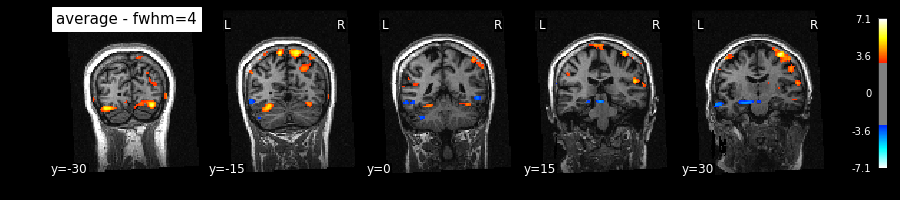

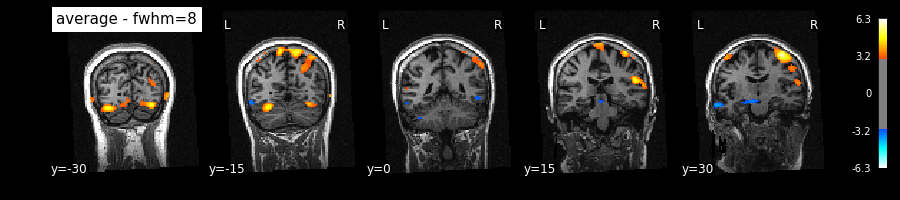

In [14]:
from nilearn.plotting import plot_stat_map
anatimg = '/output/datasink/preproc/sub-01/task-fingerfootlips/sub-01_ses-test_T1w_resample.nii'
plot_stat_map(
    '/output/datasink/1stLevel/sub-01/fwhm-4/spmT_0001.nii', title='average - fwhm=4',
    bg_img=anatimg, threshold=3, display_mode='y', cut_coords=(-30, -15, 0, 15, 30), dim=-1)
plot_stat_map(
    '/output/datasink/1stLevel/sub-01/fwhm-8/spmT_0001.nii', title='average - fwhm=8',
    bg_img=anatimg, threshold=3, display_mode='y', cut_coords=(-30, -15, 0, 15, 30), dim=-1)

Now, let's look at the three contrasts **`finger`**, **`foot`**, **`lips`**.

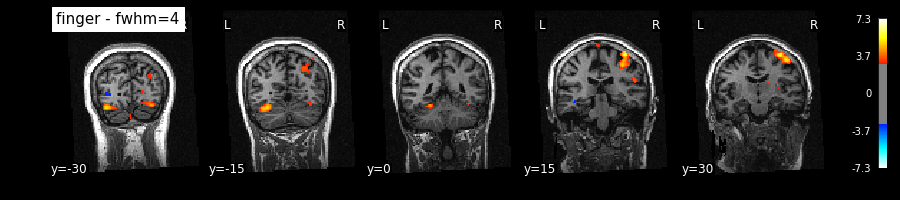

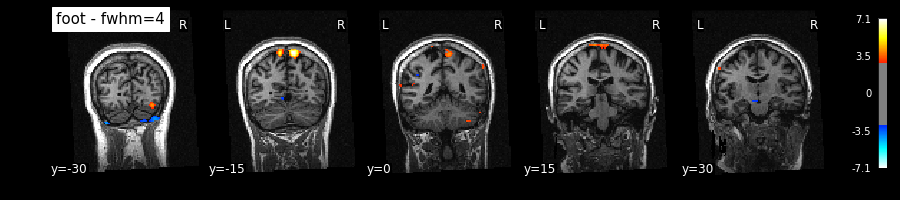

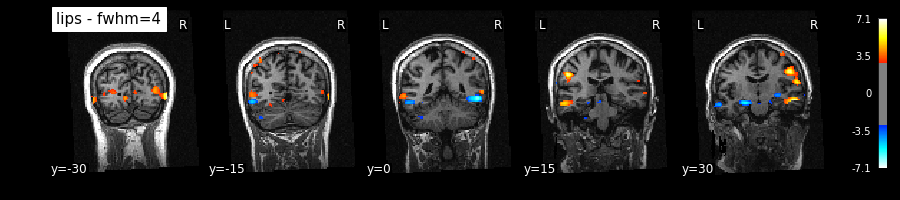

In [15]:
plot_stat_map(
    '/output/datasink/1stLevel/sub-01/fwhm-4/spmT_0002.nii', title='finger - fwhm=4',
    bg_img=anatimg, threshold=3, display_mode='y', cut_coords=(-30, -15, 0, 15, 30), dim=-1)
plot_stat_map(
    '/output/datasink/1stLevel/sub-01/fwhm-4/spmT_0003.nii', title='foot - fwhm=4',
    bg_img=anatimg, threshold=3, display_mode='y', cut_coords=(-30, -15, 0, 15, 30), dim=-1)
plot_stat_map(
    '/output/datasink/1stLevel/sub-01/fwhm-4/spmT_0004.nii', title='lips - fwhm=4',
    bg_img=anatimg, threshold=3, display_mode='y', cut_coords=(-30, -15, 0, 15, 30), dim=-1)

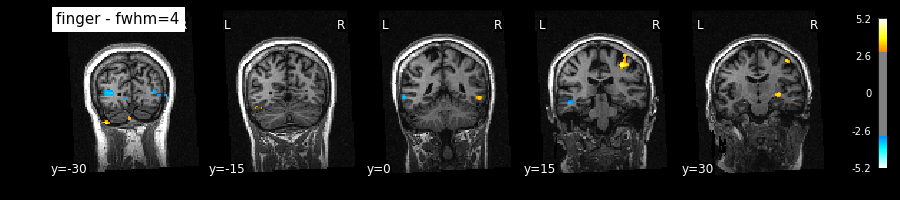

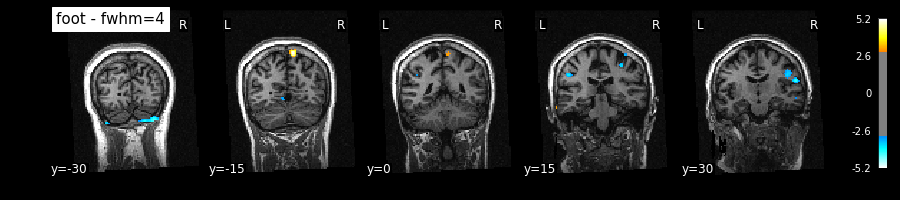

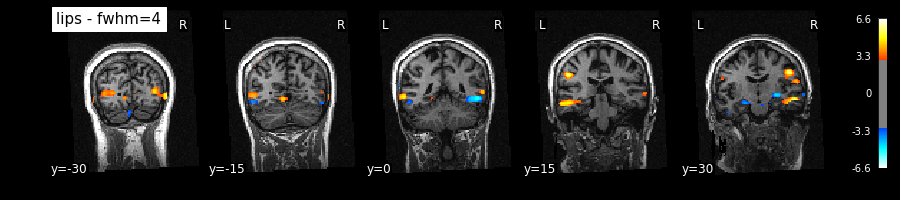

In [16]:
plot_stat_map(
    '/output/datasink/1stLevel/sub-01/fwhm-4/spmT_0005.nii', title='finger - fwhm=4',
    bg_img=anatimg, threshold=3, display_mode='y', cut_coords=(-30, -15, 0, 15, 30), dim=-1)
plot_stat_map(
    '/output/datasink/1stLevel/sub-01/fwhm-4/spmT_0006.nii', title='foot - fwhm=4',
    bg_img=anatimg, threshold=3, display_mode='y', cut_coords=(-30, -15, 0, 15, 30), dim=-1)
plot_stat_map(
    '/output/datasink/1stLevel/sub-01/fwhm-4/spmT_0007.nii', title='lips - fwhm=4',
    bg_img=anatimg, threshold=3, display_mode='y', cut_coords=(-30, -15, 0, 15, 30), dim=-1)